In [1]:
from tensorflow.keras import layers
import tensorflow_addons as tfa
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt

tf.random.set_seed(42)
np.random.seed(42)

In [24]:
import tensorflow as tf
from skimage.transform import resize

from tensorflow.keras.regularizers import l2
# tf.logging.set_verbosity(tf.logging.ERROR)
from tensorflow.keras.models import Model
from tensorflow.keras.applications import mobilenet_v2, mobilenet, resnet50, densenet
from tensorflow.keras.layers import Dense, MaxPooling2D, Conv2D, Flatten, \
    BatchNormalization, Activation, GlobalAveragePooling2D, DepthwiseConv2D, \
    Dropout, ReLU, Concatenate, Conv2DTranspose, Input, add

from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import backend as K

from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
import math
from tensorflow.keras.callbacks import CSVLogger
from datetime import datetime

import cv2
import os.path
from tensorflow.keras.utils import plot_model
from scipy.spatial import distance
import scipy.io as sio

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

In [3]:
x_val = x_train[-5000:]
y_val = y_train[-5000:]
x_train = x_train[:-5000]
y_train = y_train[:-5000]

In [4]:
x_train.shape

(55000, 28, 28)

In [5]:
x_val.shape

(5000, 28, 28)

In [7]:
y_train.shape

(55000,)

In [8]:
# adding one dimension to each as its black & white having one channel
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_val = x_val.reshape(x_val.shape[0], x_val.shape[1], x_val.shape[2], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)

In [9]:
x_train.shape

(55000, 28, 28, 1)

In [10]:
x_val.shape

(5000, 28, 28, 1)

In [11]:
x_test.shape

(10000, 28, 28, 1)

In [12]:
# Normalising
x_train = x_train/255.0
x_val = x_val/255.0
x_test = x_test/255.0

In [16]:
input_shape=[28, 28, 1]
output_shape=10

In [17]:
# convert labels to categorical
y_train = tf.keras.utils.to_categorical(y_train, output_shape)
y_val = tf.keras.utils.to_categorical(y_val, output_shape)
y_test = tf.keras.utils.to_categorical(y_test, output_shape)

In [41]:
def sample_res_net_v0(input_shape, output_shape):
    """
    :param input_shape: [28, 28, 1]
    :param output_shape: 10
    :return:
    """
    input = Input(shape=(input_shape[0], input_shape[1], input_shape[2]))

    '''block_1'''
    b1_cnv2d_1 = Conv2D(filters=16, kernel_size=(3, 3), strides=(2, 2), padding='same',
                     use_bias=False, name='b1_cnv2d_1', kernel_initializer='normal')(input)
    b1_relu_1 = ReLU(name='b1_relu_1')(b1_cnv2d_1)
    b1_bn_1 = BatchNormalization(epsilon=1e-3, momentum=0.999, name='b1_bn_1')(b1_relu_1)  # size: 14*14

    b1_cnv2d_2 = Conv2D(filters=32, kernel_size=(1, 1), strides=(2, 2), padding='same',
                        use_bias=False, name='b1_cnv2d_2', kernel_initializer='normal')(b1_bn_1)
    b1_relu_2 = ReLU(name='b1_relu_2')(b1_cnv2d_2)
    b1_out = BatchNormalization(epsilon=1e-3, momentum=0.999, name='b1_out')(b1_relu_2)  # size: 14*14

    '''block 2'''
    b2_cnv2d_1 = Conv2D(filters=32, kernel_size=(1, 1), strides=(1, 1), padding='same',
                        use_bias=False, name='b2_cnv2d_1', kernel_initializer='normal')(b1_out)
    b2_relu_1 = ReLU(name='b2_relu_1')(b2_cnv2d_1)
    b2_bn_1 = BatchNormalization(epsilon=1e-3, momentum=0.999, name='b2_bn_1')(b2_relu_1)  # size: 14*14

    b2_add = add([b1_out, b2_bn_1])  #

    b2_cnv2d_2 = Conv2D(filters=64, kernel_size=(3, 3), strides=(2, 2), padding='same',
                        use_bias=False, name='b2_cnv2d_2', kernel_initializer='normal')(b2_add)
    b2_relu_2 = ReLU(name='b2_relu_2')(b2_cnv2d_2)
    b2_out = BatchNormalization(epsilon=1e-3, momentum=0.999, name='b2_bn_2')(b2_relu_2)  # size: 7*7

    '''block 3'''
    b3_cnv2d_1 = Conv2D(filters=64, kernel_size=(1, 1), strides=(1, 1), padding='same',
                        use_bias=False, name='b3_cnv2d_1', kernel_initializer='normal')(b2_out)
    b3_relu_1 = ReLU(name='b3_relu_1')(b3_cnv2d_1)
    b3_bn_1 = BatchNormalization(epsilon=1e-3, momentum=0.999, name='b3_bn_1')(b3_relu_1)  # size: 7*7

    b3_add = add([b2_out, b3_bn_1])  #

    b3_cnv2d_2 = Conv2D(filters=128, kernel_size=(3, 3), strides=(2, 2), padding='same',
                        use_bias=False, name='b3_cnv2d_2', kernel_initializer='normal')(b3_add)
    b3_relu_2 = ReLU(name='b3_relu_2')(b3_cnv2d_2)
    b3_out = BatchNormalization(epsilon=1e-3, momentum=0.999, name='b3_out')(b3_relu_2)  # size: 3*3

    '''block 4'''
    b4_avg_p = GlobalAveragePooling2D()(b3_out)
    output = Dense(output_shape, name='model_output', activation='softmax',
                   kernel_initializer='he_uniform')(b4_avg_p)

    model = Model(input, output)

    model_json = model.to_json()

    with open("sample_res_net_v0.json", "w") as json_file:
        json_file.write(model_json)
    model.summary()
    return model


sample_res_net_v0(input_shape, output_shape)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 b1_cnv2d_1 (Conv2D)            (None, 14, 14, 16)   144         ['input_3[0][0]']                
                                                                                                  
 b1_relu_1 (ReLU)               (None, 14, 14, 16)   0           ['b1_cnv2d_1[0][0]']             
                                                                                                  
 b1_bn_1 (BatchNormalization)   (None, 14, 14, 16)   64          ['b1_relu_1[0][0]']              
                                                                                            

In [42]:
model_1 = sample_res_net_v0(input_shape=input_shape, output_shape=output_shape)

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 b1_cnv2d_1 (Conv2D)            (None, 14, 14, 16)   144         ['input_4[0][0]']                
                                                                                                  
 b1_relu_1 (ReLU)               (None, 14, 14, 16)   0           ['b1_cnv2d_1[0][0]']             
                                                                                                  
 b1_bn_1 (BatchNormalization)   (None, 14, 14, 16)   64          ['b1_relu_1[0][0]']              
                                                                                            

In [43]:
model_1.compile(loss='categorical_crossentropy',
                        optimizer=Adam(),
                        metrics=['accuracy'])

In [44]:
history = model_1.fit(x_train, y_train,
                              batch_size=100,
                              epochs=10,
                              validation_data=(x_val, y_val))

Epoch 1/10
550/550 [==============================] - 19s 32ms/step - loss: 0.2265 - accuracy: 0.9322 - val_loss: 2.5401 - val_accuracy: 0.0988
Epoch 2/10
550/550 [==============================] - 16s 29ms/step - loss: 0.0723 - accuracy: 0.9782 - val_loss: 3.0100 - val_accuracy: 0.0992
Epoch 3/10
550/550 [==============================] - 16s 29ms/step - loss: 0.0497 - accuracy: 0.9848 - val_loss: 3.7247 - val_accuracy: 0.1874
Epoch 4/10
550/550 [==============================] - 16s 29ms/step - loss: 0.0386 - accuracy: 0.9875 - val_loss: 4.8337 - val_accuracy: 0.1104
Epoch 5/10
550/550 [==============================] - 16s 29ms/step - loss: 0.0294 - accuracy: 0.9913 - val_loss: 3.9577 - val_accuracy: 0.1708
Epoch 6/10
550/550 [==============================] - 16s 29ms/step - loss: 0.0235 - accuracy: 0.9928 - val_loss: 2.0933 - val_accuracy: 0.4532
Epoch 7/10
550/550 [==============================] - 17s 30ms/step - loss: 0.0209 - accuracy: 0.9936 - val_loss: 1.3082 - val_accuracy:

In [45]:
model_1.save("res_model.hd5")

INFO:tensorflow:Assets written to: res_model.hd5\assets


C:\Users\Rana\anaconda3\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
C:\Users\Rana\anaconda3\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


In [46]:
def show_figures(history):
        plt.plot(history['accuracy'])
        plt.plot(history['val_accuracy'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'validation'])
        plt.savefig('accuracy')


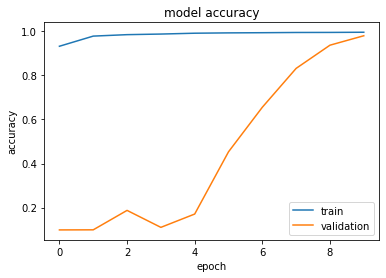

In [47]:
show_figures(history.history)

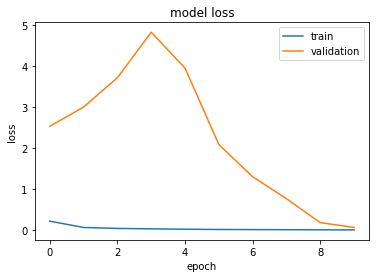

In [48]:

def show_figures(history):
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'])
    plt.savefig('loss')
    
show_figures(history.history)